This notebook will describe experiments related to DUD-E

In [1]:
import pickle
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import torch
import seaborn as sns
import pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=17)
plt.rc('figure', titlesize=20)


In [2]:
def compute_enrichment_factor(scores, labels, n_percent):
    # this variant implements the equation from Xiaohua's paper
    
    sample_n = int(np.ceil(n_percent * labels.shape[0]))
    
    sorted_scores = sorted(zip(scores, labels), key=lambda x: x[0], reverse=True)

    top_n_sorted_scores = sorted_scores[:sample_n]

    # counting number of true positives in top x% of sorted compounds
    actives_sampled = sum([y for x, y in top_n_sorted_scores])
    # labels are binary, sum to count number of actives
    actives_database = sum(labels)

    norm_factor = (sample_n/len(labels))

    return (actives_sampled / actives_database) * (labels.shape[0]/sample_n)


In [3]:
data_p = Path("/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results")

In [4]:
list(data_p.glob("dude.random*.pkl"))[0].name

'dude.random.dyr.ecfp.atomwise.0.pkl'

In [5]:
dude_target_names = list(set([x.name.split('.')[2] for x in list(data_p.glob("dude.random*.pkl"))]))
dude_target_names

['nram',
 'hivrt',
 'src',
 'pgh1',
 'pur2',
 'aldr',
 'thrb',
 'ace',
 'mcr',
 'pde5a',
 'try1',
 'ada',
 'prgr',
 'parp1',
 'fa10',
 'gcr',
 'cdk2',
 'mk14',
 'dyr',
 'hmdh',
 'aces',
 'pnph',
 'hs90a',
 'pygm',
 'vgfr2',
 'andr',
 'pgh2',
 'ampc',
 'pparg',
 'sahh',
 'egfr',
 'esr1',
 'comt',
 'rxra',
 'kith',
 'hivpr',
 'inha',
 'bace1']

In [6]:
def load_pkl(pkl_path, model, return_sizes=False):
    
    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed
        
        
        if 0 in data.keys():
            data = data[0]

        
        if "encode_time" not in data.keys():
            return
    
    if isinstance(data["y_true"], np.ndarray):
        y_true = data["y_true"]
    else:
        y_true = np.concatenate(data["y_true"]) 
    y_pred = np.array(data["y_pred"])

    
    eta = np.array(data["eta"])

    if np.unique(y_true).shape[0] < 2 :
        metric = 0
    else:
        metric = recall_score(y_pred=y_pred, y_true=y_true)
        if model in ["rf", "mlp"]:
            eta= eta[:, 1]

    if return_sizes:
        return y_true, y_pred, eta, metric, data["encode_time"], data["train_time"], data["test_time"], data["train_size"], data["test_size"]
    else:
        return y_true, y_pred, eta, metric, data["encode_time"], data["train_time"], data["test_time"]


# DUD-E results

In [7]:
green_color_pal = sns.color_palette("Greens", 10)
blue_color_pal = sns.color_palette("Blues", 10)
rocket_color_pal = sns.color_palette("rocket", 10)

In [8]:
green_color_pal

[(0.9176931949250289, 0.9684275278738947, 0.901361014994233),
 (0.8459054209919262, 0.9399307958477509, 0.8228219915417148),
 (0.7558477508650518, 0.9033910034602076, 0.7290426758938869),
 (0.6436447520184544, 0.8561476355247981, 0.6197923875432525),
 (0.5185697808535179, 0.7983391003460207, 0.5150941945405614),
 (0.3827450980392157, 0.7332564398308343, 0.42737408688965783),
 (0.2452133794694348, 0.6602537485582468, 0.35695501730103807),
 (0.1566320645905421, 0.5657670126874279, 0.28608996539792386),
 (0.06082276047673972, 0.47958477508650516, 0.21599384851980008),
 (0.0, 0.38268358323721646, 0.15398692810457515)]

In [9]:
blue_color_pal

[(0.8978854286812764, 0.939038831218762, 0.977362552864283),
 (0.828881199538639, 0.8937639369473279, 0.954725105728566),
 (0.7506343713956171, 0.8478431372549019, 0.9282122260668974),
 (0.6325259515570935, 0.7976470588235294, 0.8868742791234141),
 (0.491764705882353, 0.7219684736639754, 0.8547789311803152),
 (0.36159938485198, 0.6427374086889658, 0.8165782391387928),
 (0.24816608996539793, 0.5618915801614763, 0.7709803921568628),
 (0.15072664359861593, 0.4644521337946943, 0.7207843137254902),
 (0.07481737793156479, 0.3732564398308343, 0.6552095347943099),
 (0.03137254901960784, 0.28161476355247983, 0.5582622068435218)]

In [10]:
rocket_color_pal

[(0.13501631, 0.07585609, 0.19044109),
 (0.26930915, 0.1091727, 0.2772502),
 (0.41282936, 0.12164769, 0.33467689),
 (0.57077365, 0.11135597, 0.35827146),
 (0.72398193, 0.08688725, 0.33943958),
 (0.85281737, 0.15657772, 0.27909826),
 (0.93078135, 0.31373977, 0.24468803),
 (0.95626788, 0.49187351, 0.33985601),
 (0.96388426, 0.64484214, 0.4861196),
 (0.96810471, 0.78634563, 0.66773889)]

In [11]:
color_dict = {
    "smiles-pe.atomwise.0": rocket_color_pal[3],
    "smiles-pe.bpe.0": rocket_color_pal[3],   
#     "smiles-pe.ngram.1": color_pal[0],
#     "smiles-pe.ngram.2": "steelblue",
#     "smiles-pe.ngram.3": "steelblue",
#     "selfies.None": "purple",
#     "selfies.selfies-charwise": "purple",
"selfies.None": green_color_pal[4],
#     "selfies.selfies-charwise": color_pal[2],
    "ecfp": green_color_pal[6],
    "rp": green_color_pal[8],
    "rf": blue_color_pal[4],
#     "openhd": "green",
    "mlp": blue_color_pal[4],
#     "Vina": rocket_color_pal[-2]
}

marker_dict = {
#     "smiles-pe": "+",
    "smiles-pe.atomwise.0": "+",
    "smiles-pe.bpe.0": "+",   
#     "smiles-pe.ngram.1": "+",
#     "smiles-pe.ngram.2": "+",
#     "smiles-pe.ngram.3": "+",
    "selfies.None": "*",
#     "selfies.selfies-charwise": "*",
    "ecfp": "+",
    "rp": "+",
    "rf": "^",
#     "openhd": "*",
    "mlp": "+",
#     "Vina": "+"
}


model_order_list = [
    ("smiles-pe.atomwise.0", "MoleHD-Atomw."),
    ("smiles-pe.bpe.0", "MoleHD-BPE"),
#     ("smiles-pe.ngram.1", "SMILES uni-gram"),
    ("selfies.None", "HDBind-SELFIES"),
#     ("selfies.selfies-charwise", "SELFIES uni-gram"),
    ("ecfp", "HDBind-ECFP"),
    ("rp", "HDBind-ECFP+RP"),
    ("rf", "RF"),
    ("mlp", "MLP"),
    ("Vina", "Vina")
]


model_name_dict = {
    "smiles-pe.atomwise.0": "MoleHD-Atomw.", 
    "smiles-pe.bpe.0": "MoleHD-BPE",
#     "smiles-pe.ngram.1": "SMILES uni-gram",
    "selfies.None": "HDBind-SELFIES",
#     "selfies.selfies-charwise": "SELFIES uni-gram",
    "ecfp": "HDBind-ECFP",
    "rp": "HDBind-ECFP-RP",
    "rf": "RF",
    "mlp": "MLP",
    "Vina": "Vina"
}


linestyle_dict = {
    "smiles-pe.atomwise.0": "-", 
    "smiles-pe.bpe.0": ":",
    "selfies.None": "-",
    "ecfp": ":",
    "rp": "-.",
    "rf": "-",
    "mlp": ":",
    "Vina": "-"
}





########################################################

# color_pal = sns.color_palette("Greens", 4)
# blue_color_pal = sns.color_palette("Blues", 4)
# color_dict = {
#     "smiles-pe.atomwise.0": color_pal[0],
#     "smiles-pe.bpe.0": color_pal[0],   
#     "smiles-pe.ngram.1": color_pal[0],
# #     "smiles-pe.ngram.2": "steelblue",
# #     "smiles-pe.ngram.3": "steelblue",
# #     "selfies.None": "purple",
# #     "selfies.selfies-charwise": "purple",
# "selfies.None": color_pal[2],
#     "selfies.selfies-charwise": color_pal[2],
#     "ecfp": color_pal[2],
#     "rp": color_pal[2],
#     "rf": blue_color_pal[1],
# #     "openhd": "green",
#     "mlp": blue_color_pal[1],
# #     "Vina": color_pal[2]
# # }

# marker_dict = {
# #     "smiles-pe": "+",
#     "smiles-pe.atomwise.0": "+",
#     "smiles-pe.bpe.0": "+",   
#     "smiles-pe.ngram.1": "+",
# #     "smiles-pe.ngram.2": "+",
# #     "smiles-pe.ngram.3": "+",
#     "selfies.None": "*",
#     "selfies.selfies-charwise": "*",
#     "ecfp": "+",
#     "rp": "+",
#     "rf": "^",
# #     "openhd": "*",
#     "mlp": "+",
# #     "Vina": "+"
# }


# model_order_list = [
#     ("smiles-pe.atomwise.0", "SMILES Atomwise"),
#     ("smiles-pe.bpe.0", "SMILES BPE"),
#     ("smiles-pe.ngram.1", "SMILES uni-gram"),
#     ("selfies.None", "SELFIES"),
#     ("selfies.selfies-charwise", "SELFIES uni-gram"),
#     ("ecfp", "ECFP"),
#     ("rp", "ECFP-RP"),
#     ("rf", "RF"),
#     ("mlp", "MLP"),
#     ("Vina", "Vina")
# ]

In [12]:
def aggregate_dude_results(dataset, split):
    
    model_metric_dict = {}
    
    
#     enrich_1_f, enrich_1_ax = plt.subplots(1,1, figsize=(13,6))
#     enrich_10_f, enrich_10_ax = plt.subplots(1,1, figsize=(13,6))

#     enrich_f, enrich_ax = plt.subplots(1,2, figsize=(15,6), sharex=True, sharey=True)
    enrich_f, enrich_ax = plt.subplots(2,1, figsize=(12,10), sharex=True, sharey=False)
    enrich_ax = enrich_ax.flatten()
    enrich_1_ax, enrich_10_ax = enrich_ax[0], enrich_ax[1]
#     enrich_10_f, enrich_10_ax = plt.subplots(1,1, figsize=(13,6))


    
#     enrich_1_f.suptitle("Enrichment at 1\% of database")
#     enrich_10_f.suptitle("Enrichment at 10\% of database")
    
    f, ax = plt.subplots(1,3, figsize=(16,6))
    ax = ax.flatten()

    for model, color in color_dict.items():
        
        marker = marker_dict[model]
#         color, marker = model_tup
        
        model_metric_dict[model] = []
        
        metric_list = []
        encode_time_list = []
        train_time_list = []
        test_time_list = []
        eta_list = []
        data_path_list = list(data_p.glob(f"{dataset}.{split}.*.{model}*pkl"))
        
        train_size_list = []
        test_size_list = []
        target_size_list = []
        
        
        enrich_1_list = []
        enrich_10_list = []
        
        for path in data_path_list:
            
            
            print(path)
#             continue
#             import pdb 
#             pdb.set_trace()
            target = path.name.split(".")[2]
            split = path.name.split(".")[1]
            
            
            
            split_file = f"/usr/WS2/atom/gbsa_modeling/dude_smiles/{target}_gbsa_smiles_with_base_rdkit_smiles_train_valid_test_{split}_{split}.csv"
            split_df = pd.read_csv(split_file)
            
            train_size = split_df[split_df["subset"] == "train"].shape[0] 
            test_size = split_df[split_df["subset"] == "test"].shape[0]
            
            y_true, y_pred, eta, m, encode_time, train_time, test_time = load_pkl(path, model=model, return_sizes=False)
            

            if m is None:
                pass
            else:
                metric_list.append(m)
                encode_time_list.append(encode_time)
                train_time_list.append(train_time/10) # because i retrained 10 times
                test_time_list.append(test_time)
                eta_list.append(eta)
                train_size_list.append(train_size)
                test_size_list.append(test_size)
                
                
                
                enrich_1 = compute_enrichment_factor(scores=eta, labels=y_true, n_percent=.01)
                enrich_1_list.append(enrich_1)
                
                enrich_10 = compute_enrichment_factor(scores=eta, labels=y_true, n_percent=.1)
                enrich_10_list.append(enrich_10)

                target_size_list.append(train_size+test_size)
                
                model_metric_dict[model].append((m, enrich_1, enrich_10, train_size, test_size, train_time, test_time))
                
        sorted_metric_list = [x for _, x in sorted(zip(target_size_list, metric_list), key=lambda pair: pair[0])]
        sorted_encode_time_list = [x for _, x in sorted(zip(target_size_list, encode_time_list), key=lambda pair: pair[0])]
        sorted_train_time_list = [x for _, x in sorted(zip(target_size_list, train_time_list), key=lambda pair: pair[0])]
        sorted_test_time_list = [x for _, x in sorted(zip(target_size_list, test_time_list), key=lambda pair: pair[0])]
        sorted_enrich_1_list = [x for _, x in sorted(zip(target_size_list, enrich_1_list), key=lambda pair: pair[0])]
        sorted_enrich_10_list = [x for _, x in sorted(zip(target_size_list, enrich_10_list), key=lambda pair: pair[0])]
        sorted_train_size_list = sorted(train_size_list)
        
        
        if model not in ["rf", "mlp"]:
            sns.scatterplot(x=[x for x in range(len(target_size_list))], y=sorted_encode_time_list, ax=ax[1], color=color, marker=marker, label=model)
        sns.scatterplot(x=[x for x in range(len(target_size_list))], y=sorted_train_time_list, ax=ax[2], color=color, marker=marker, label=model)

    ax[0].set_ylabel("roc-auc-score")
    ax[0].set_xlabel("DUD-E target")

    plt.legend()
    

    return f, ax, enrich_f, enrich_1_ax, enrich_10_ax, model_metric_dict




/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.dyr.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.inha.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.aces.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.cdk2.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.kith.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.esr1.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.gcr.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.rxra.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.ampc.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.hivrt.smiles-pe.atomwi

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.pgh1.selfies.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.bace1.selfies.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.nram.selfies.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.pygm.selfies.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.mcr.selfies.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.pgh2.selfies.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.parp1.selfies.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.ada.selfies.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.comt.selfies.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.pparg.selfies.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdp

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.hs90a.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.ace.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.pde5a.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.src.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.hivpr.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.aldr.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.try1.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.andr.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.fa10.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.sahh.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/

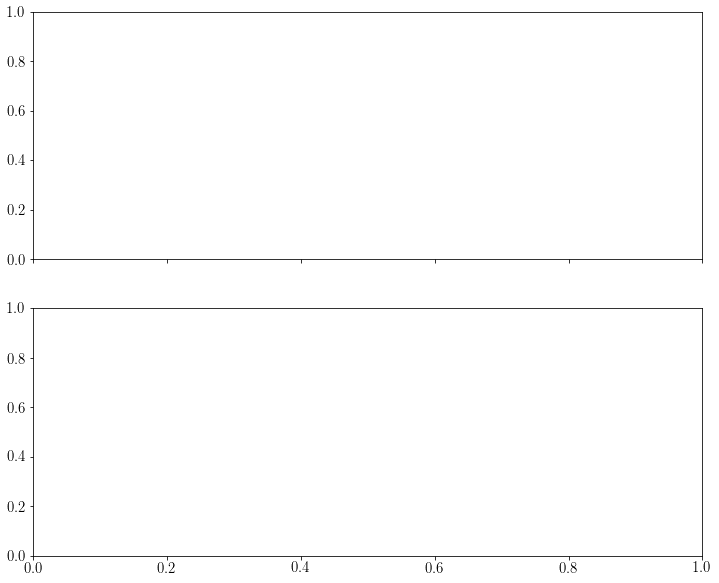

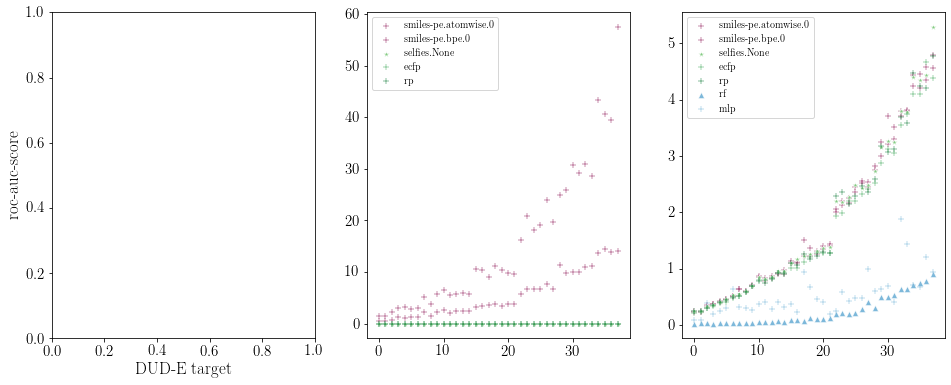

In [13]:
dude_f, dude_ax, dude_enrich_f, dude_enrich_1_ax, dude_enrich_10_ax, model_metric_dict = aggregate_dude_results(dataset="dude", split="random")


In [14]:
model_metric_dict.keys()

dict_keys(['smiles-pe.atomwise.0', 'smiles-pe.bpe.0', 'selfies.None', 'ecfp', 'rp', 'rf', 'mlp'])

In [15]:
model_metric_dict

{'smiles-pe.atomwise.0': [(0.5185185185185185,
   array([52.03703704]),
   array([9.59548201]),
   11049,
   1382,
   20.635817050933838,
   1.8391976356506348),
  (0.5,
   array([26.]),
   array([8.66666667]),
   1627,
   204,
   3.4766929149627686,
   0.04956245422363281),
  (0.3888888888888889,
   array([50.54671717]),
   array([8.59886783]),
   16792,
   2099,
   32.400315046310425,
   0.4865560531616211),
  (0.37142857142857144,
   array([61.62417582]),
   array([8.28246499]),
   19826,
   2479,
   37.958051681518555,
   0.5052764415740967),
  (0.5,
   array([44.66666667]),
   array([9.92592593]),
   2121,
   266,
   4.328226327896118,
   0.09271049499511719),
  (0.20512820512820512,
   array([40.51282051]),
   array([9.48717949]),
   12521,
   1566,
   23.580803632736206,
   0.37378787994384766),
  (0.45454545454545453,
   array([38.40909091]),
   array([9.03743316]),
   6632,
   830,
   12.62043023109436,
   0.19605159759521484),
  (0.2222222222222222,
   array([62.55555556]),
 

In [16]:
[len(x) for x in model_metric_dict.values()]

[38, 38, 38, 38, 38, 38, 38]

In [17]:
model_metric_df = pd.DataFrame(model_metric_dict)
model_metric_df_list = [pd.DataFrame({"metric": [tup[0] for tup in model_metric_df[col].values], 
                                      "enrich-1": [tup[1] for tup in model_metric_df[col].values],
                                      "enrich-10": [tup[2] for tup in model_metric_df[col].values],
                                      "model": [col]*len(model_metric_df),
                                       "train_size": [tup[3] for tup in model_metric_df[col].values],
                                     "test_size": [tup[4] for tup in model_metric_df[col].values],
                                     "train_time": [tup[5] for tup in model_metric_df[col].values],
                                     "test_time": [tup[6] for tup in model_metric_df[col].values]})
                                     for col in model_metric_df.columns]


model_metric_df = pd.concat(model_metric_df_list)

model_metric_df["latency"] = model_metric_df["test_time"] / model_metric_df["test_size"]

# model_metric_df["order-id"] = model_metric_df["model"].apply(lambda x: model_order_dict[x])

model_metric_df


,metric,enrich-1,enrich-10,model,train_size,test_size,train_time,test_time,latency
0,0.518519,[52.037037037037045],[9.595482006829524],smiles-pe.atomwise.0,11049,1382,20.635817,1.839198,0.001331
1,0.500000,[26.0],[8.666666666666668],smiles-pe.atomwise.0,1627,204,3.476693,0.049562,0.000243
2,0.388889,[50.54671717171717],[8.598867825171142],smiles-pe.atomwise.0,16792,2099,32.400315,0.486556,0.000232
3,0.371429,[61.62417582417582],[8.282464985994398],smiles-pe.atomwise.0,19826,2479,37.958052,0.505276,0.000204
4,0.500000,[44.666666666666664],[9.925925925925926],smiles-pe.atomwise.0,2121,266,4.328226,0.092710,0.000349
...,...,...,...,...,...,...,...,...,...
33,0.955556,[16.68888888888889],[9.881578947368421],mlp,5960,746,2.219042,0.004462,0.000006
34,1.000000,[45.285714285714285],[9.90625],mlp,4961,621,4.144523,0.023033,0.000037
35,0.900000,[32.84],[9.951515151515151],mlp,12890,1612,4.693374,0.021507,0.000013
36,1.000000,[47.285714285714285],[9.735294117647058],mlp,2620,328,6.397740,0.020010,0.000061


In [18]:
model_metric_df['enrich-1'] = model_metric_df['enrich-1'].apply(lambda x: float(np.array(x)))
model_metric_df['enrich-10'] = model_metric_df['enrich-10'].apply(lambda x: float(np.array(x)))

<>:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_3553678/560297459.py:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  ax=dude_ax[0], palette=color_dict, order=[x[0] for x in model_order_list if x[0] is not "Vina"])


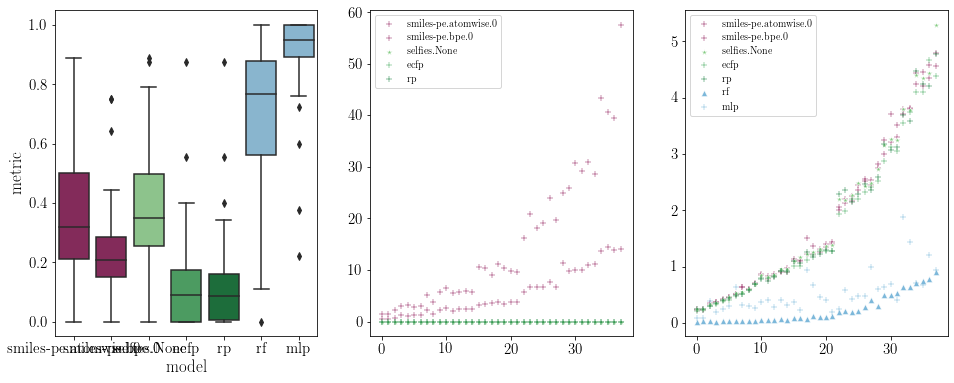

In [19]:
sns.boxplot(data=model_metric_df, x="model", y="metric", 
            ax=dude_ax[0], palette=color_dict, order=[x[0] for x in model_order_list if x[0] is not "Vina"])
dude_f

## Vina Docking baseline

In [20]:
vina_root_p = Path("/p/lustre1/jones289/DUDE-38/")


color_dict.update({"Vina": "salmon"})



vina_path_list = [path for path in vina_root_p.glob("*-active-summary.txt")]


df_list = []


# root_dude_dir = Path("/g/g13/jones289/workspace/hd-cuda-master/datasets/dude/dude_smiles/")
root_dude_dir = Path("/usr/workspace/atom/gbsa_modeling/dude_smiles/")
for idx, path in  enumerate(vina_path_list):
#     print(idx, path)
    target = path.name.split(".")[0].split("-")[0]
    print(target, idx+1, path)
    
    # for some reason don't have inactive data for abl1
    if target in ["abl1"]:
        continue
    if target in dude_target_names:
    
        active_df = pd.read_csv(f"/p/lustre1/jones289/DUDE-38/{target}-active-summary.txt", header=None, delim_whitespace=True)
        active_df['y_true'] = [1] * len(active_df)
    
        decoy_df = pd.read_csv(f"/p/lustre1/jones289/DUDE-38/{target}-decoy-summary.txt", header=None, delim_whitespace=True)
        decoy_df['y_true'] = [0] * len(decoy_df)
    
    
        target_df = pd.concat([active_df, decoy_df])
        
        target_df["target"] = [target] * len(target_df)
    
        target_df["vina"] = target_df[2]
        target_df["gbsa"] = target_df[3]
        
        target_df["cmpd_id"] = target_df[1]
        
        target_df["target_size"] = target_df.shape[0]
        
#         import pdb
#         pdb.set_trace()
        random_split_df = pd.read_csv(root_dude_dir/ Path(f"{target}_gbsa_smiles_with_base_rdkit_smiles_train_valid_test_random_random.csv"))
        
        
#         import pdb
#         pdb.set_trace()

        # we only use the scores from the test set to attempt an even comparison
    
        merged_df = pd.merge(target_df, random_split_df, on="cmpd_id")
        merged_df = merged_df.loc[merged_df['subset'] == "test"]

        print(merged_df.shape)
    
        df_list.append(merged_df)
    else:
        pass

df = pd.concat(df_list)
    

pgh1 1 /p/lustre1/jones289/DUDE-38/pgh1-active-summary.txt
(941, 11)
rxra 2 /p/lustre1/jones289/DUDE-38/rxra-active-summary.txt
(568, 11)
pnph 3 /p/lustre1/jones289/DUDE-38/pnph-active-summary.txt
(655, 11)
ampc 4 /p/lustre1/jones289/DUDE-38/ampc-active-summary.txt
(295, 11)
try1 5 /p/lustre1/jones289/DUDE-38/try1-active-summary.txt
(782, 11)
parp1 6 /p/lustre1/jones289/DUDE-38/parp1-active-summary.txt
(2673, 11)
comt 7 /p/lustre1/jones289/DUDE-38/comt-active-summary.txt
(406, 11)
andr 8 /p/lustre1/jones289/DUDE-38/andr-active-summary.txt
(643, 11)
sahh 9 /p/lustre1/jones289/DUDE-38/sahh-active-summary.txt
(336, 11)
ace 10 /p/lustre1/jones289/DUDE-38/ace-active-summary.txt
(1587, 11)
cdk2 11 /p/lustre1/jones289/DUDE-38/cdk2-active-summary.txt
(2604, 11)
fgfr1 12 /p/lustre1/jones289/DUDE-38/fgfr1-active-summary.txt
hmdh 13 /p/lustre1/jones289/DUDE-38/hmdh-active-summary.txt
(789, 11)
nram 14 /p/lustre1/jones289/DUDE-38/nram-active-summary.txt
(587, 11)
aces 15 /p/lustre1/jones289/DUDE-3

In [21]:
set(df['target'].values.tolist())

{'ace',
 'aces',
 'ada',
 'aldr',
 'ampc',
 'andr',
 'bace1',
 'cdk2',
 'comt',
 'dyr',
 'egfr',
 'esr1',
 'fa10',
 'gcr',
 'hivpr',
 'hivrt',
 'hmdh',
 'hs90a',
 'inha',
 'kith',
 'mcr',
 'mk14',
 'nram',
 'parp1',
 'pde5a',
 'pgh1',
 'pgh2',
 'pnph',
 'pparg',
 'prgr',
 'pur2',
 'pygm',
 'rxra',
 'sahh',
 'src',
 'thrb',
 'try1',
 'vgfr2'}

In [22]:
df

,0,1,2,3,y_true,target,vina,gbsa,cmpd_id,target_size,subset
65,158,CHEMBL178355,-7.3,-23.4889,1,pgh1,-7.3,-23.4889,CHEMBL178355,9475,test
68,161,CHEMBL283267,-7.7,-26.2514,1,pgh1,-7.7,-26.2514,CHEMBL283267,9475,test
69,162,CHEMBL184374,-7.1,-22.7434,1,pgh1,-7.1,-22.7434,CHEMBL184374,9475,test
79,171,CHEMBL433892,-7.3,-29.1098,1,pgh1,-7.3,-29.1098,CHEMBL433892,9475,test
90,180,CHEMBL404928,-6.6,-22.1502,1,pgh1,-6.6,-22.1502,CHEMBL404928,9475,test
...,...,...,...,...,...,...,...,...,...,...,...
8660,994,ZINC35141443,-7.8,-28.5967,0,gcr,-7.8,-28.5967,ZINC35141443,11247,test
8661,9941,ZINC08387402,-7.3,-5.9566,0,gcr,-7.3,-5.9566,ZINC08387402,11247,test
8678,9969,ZINC64795840,-7.4,-20.0953,0,gcr,-7.4,-20.0953,ZINC64795840,11247,test
8698,9992,ZINC02647100,-5.5,-11.0534,0,gcr,-5.5,-11.0534,ZINC02647100,11247,test


In [23]:
target_size_list = []
vina_enrich_1_list = []
vina_enrich_10_list = []

for target, target_df in df.groupby("target"):
    
    ef_1 = compute_enrichment_factor(scores=np.abs(target_df["vina"]), labels=target_df["y_true"], n_percent=0.01)
    ef_10 = compute_enrichment_factor(scores=np.abs(target_df["vina"]), labels=target_df["y_true"], n_percent=0.1)

    
    target_size_list.append(target_df.shape[0])
    
    vina_enrich_1_list.append(ef_1)
    vina_enrich_10_list.append(ef_10)
    
    
    print(f"{target}, {ef_1:.4f}\t{ef_10:.4f}\t{target_df.shape[0]}")
    
sorted_vina_enrich_1_list = [x for _, x in sorted(zip(target_size_list, vina_enrich_1_list), key=lambda pair: pair[0])]
sorted_vina_enrich_10_list = [x for _, x in sorted(zip(target_size_list, vina_enrich_10_list), key=lambda pair: pair[0])]



ace, 1.6811	1.3534	1587
aces, 12.2992	4.7184	2126
ada, 0.0000	0.2302	574
aldr, 3.5769	1.5330	837
ampc, 0.0000	1.2292	295
andr, 18.3714	2.9677	643
bace1, 3.6061	2.6398	1529
cdk2, 1.4183	1.7606	2604
comt, 0.0000	0.9002	406
dyr, 0.0000	1.7635	1459
egfr, 4.3677	2.2381	3219
esr1, 3.6968	2.2181	1597
fa10, 5.4376	2.1879	1687
gcr, 0.0000	2.3696	872
hivpr, 1.3017	3.1342	3087
hivrt, 0.0000	2.6167	157
hmdh, 0.0000	0.9665	789
hs90a, 0.0000	0.0000	466
inha, 0.0000	1.7438	211
kith, 0.0000	0.5402	282
mcr, 9.7333	3.8933	146
mk14, 7.4759	2.5798	3079
nram, 0.0000	0.0000	587
parp1, 10.4211	3.9371	2673
pde5a, 8.6297	2.4922	2223
pgh1, 0.0000	1.1006	941
pgh2, 4.0780	3.1823	1725
pnph, 5.1984	2.2054	655
pparg, 5.8793	4.6167	2265
prgr, 12.3974	4.0899	967
pur2, 6.1795	5.1908	241
pygm, 0.0000	0.9015	357
rxra, 18.9333	9.9649	568
sahh, 0.0000	0.0000	336
src, 3.2879	1.9727	2992
thrb, 4.9508	4.0506	880
try1, 2.7153	1.7873	782
vgfr2, 21.6409	4.8374	1864


I think it would be good to move away from the per-target (sorted by size) scatter plot and instead make a series of box plots...this should make it easier to compare the enrichment factors as you increase the amount of data that you are allowed to screen

In [24]:
model_metric_df = pd.concat([model_metric_df, pd.DataFrame({"metric": [0]*38, "enrich-1": sorted_vina_enrich_1_list, 
                                            "enrich-10": sorted_vina_enrich_10_list,
                                          "model": ["Vina"]*38, 
                                                           })])


model_metric_df

,metric,enrich-1,enrich-10,model,train_size,test_size,train_time,test_time,latency
0,0.518519,52.037037,9.595482,smiles-pe.atomwise.0,11049.0,1382.0,20.635817,1.839198,0.001331
1,0.500000,26.000000,8.666667,smiles-pe.atomwise.0,1627.0,204.0,3.476693,0.049562,0.000243
2,0.388889,50.546717,8.598868,smiles-pe.atomwise.0,16792.0,2099.0,32.400315,0.486556,0.000232
3,0.371429,61.624176,8.282465,smiles-pe.atomwise.0,19826.0,2479.0,37.958052,0.505276,0.000204
4,0.500000,44.666667,9.925926,smiles-pe.atomwise.0,2121.0,266.0,4.328226,0.092710,0.000349
...,...,...,...,...,...,...,...,...,...
33,0.000000,10.421053,3.937058,Vina,NaN,NaN,NaN,NaN,NaN
34,0.000000,3.287912,1.972747,Vina,NaN,NaN,NaN,NaN,NaN
35,0.000000,7.475893,2.579807,Vina,NaN,NaN,NaN,NaN,NaN
36,0.000000,1.301708,3.134209,Vina,NaN,NaN,NaN,NaN,NaN


In [25]:
sns.boxplot(data=model_metric_df, x="model", y="enrich-1", ax=dude_enrich_1_ax, palette=color_dict,
           order=[x[0] for x in model_order_list])
dude_enrich_1_ax.set_title("(a) DUD-E Enrichment at 1\%", fontdict={"fontsize": 18})
dude_enrich_1_ax.tick_params(axis="x", labelrotation=22.5)
# dude_enrich_1_ax.set_ylabel("Enrch. at 1\%", rotation_mode="anchor")
dude_enrich_1_ax.set_xlabel("")
dude_enrich_1_ax.set_ylabel("")

labels = [x[1] for x in model_order_list]

dude_enrich_1_ax.set_xticklabels(labels)
# plt.tight_layout()
# dude_enrich_1_f.savefig("dude_enrich_1.png", dpi=600, bbox_inches="tight")
# dude_enrich_1_f

[]

In [26]:
sns.boxplot(data=model_metric_df, x="model", y="enrich-10", ax=dude_enrich_10_ax, palette=color_dict)
dude_enrich_10_ax.set_title("(b) DUD-E Enrichment at 10\%", fontdict={"fontsize": 18})

dude_enrich_10_ax.tick_params(axis="x", labelrotation=22.5)
# dude_enrich_10_ax.set_ylabel("Enrch. at 10\%", rotation_mode="anchor")
dude_enrich_10_ax.set_xlabel("")
dude_enrich_10_ax.set_ylabel("")

labels = [x[1] for x in model_order_list]

dude_enrich_10_ax.set_xticklabels(labels)
# plt.tight_layout()
dude_enrich_f.savefig("dude_enrich.png", dpi=600, bbox_inches="tight")
# dude_enrich_10_f

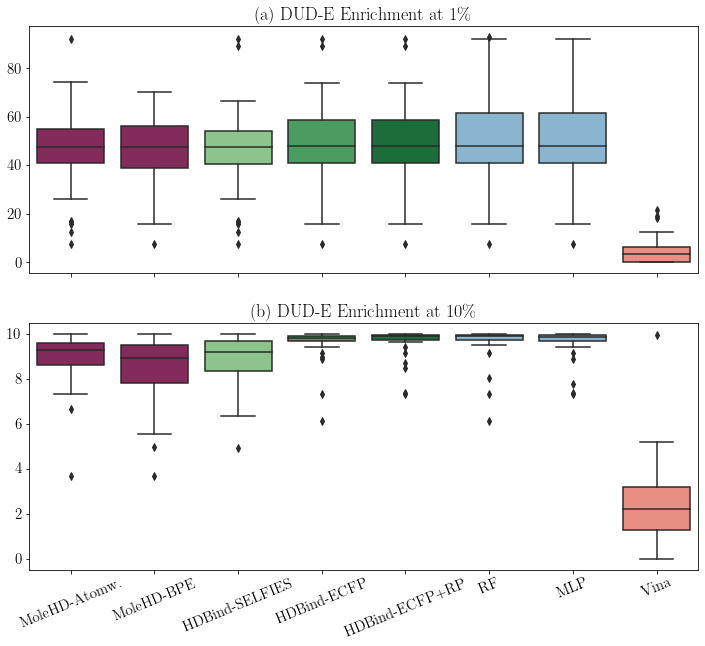

In [27]:
dude_enrich_f

In [28]:
model_metric_df.groupby('model').describe()[['enrich-1', 'enrich-10']]

enrich-1                                         \
                        count       mean        std   min        25%   
model                                                                  
Vina                     38.0   4.665199   5.764932  0.00   0.000000   
ecfp                     38.0  49.427184  18.473692  7.35  41.018336   
mlp                      38.0  49.591088  19.211518  7.35  41.018336   
rf                       38.0  50.299595  20.273109  7.35  41.018336   
rp                       38.0  49.177432  18.871126  7.35  41.018336   
selfies.None             38.0  45.974674  17.749894  7.35  40.350359   
smiles-pe.atomwise.0     38.0  46.116534  17.566428  7.35  41.018336   
smiles-pe.bpe.0          38.0  45.656780  16.402843  7.35  38.671402   

                                                      enrich-10            \
                            50%        75%        max     count      mean   
model                                                                       
Vina                   3.432418   6.104440  21.640867      38.0  2.471403   
ecfp                  47.991764  58.395833  91.857143      38.0  9.604538   
mlp                   47.991764  61.548611  91.857143      38.0  9.610994   
rf                    47.991764  61.548611  92.600000      38.0  9.633464   
rp                    47.991764  58.395833  91.857143      38.0  9.662363   
selfies.None          47.351190  54.214316  91.857143      38.0  8.846649   
smiles-pe.atomwise.0  47.351190  55.031858  91.857143      38.0  8.969861   
smiles-pe.bpe.0       47.499828  55.983340  70.090909      38.0  8.473721   

                                                                        \
                           std       min       25%       50%       75%   
model                                                                    
Vina                  1.886596  0.000000  1.260218  2.211721  3.170251   
ecfp                  0.746140  6.145833  9.677100  9.833214  9.924964   
mlp                   0.673145  7.350000  9.669355  9.886943  9.945559   
rf                    0.780525  6.145833  9.712698  9.900657  9.950733   
rp                    0.640038  7.350000  9.748017  9.905322  9.961283   
selfies.None          1.125575  4.916667  8.348585  9.177027  9.708008   
smiles-pe.atomwise.0  1.151737  3.687500  8.616096  9.276750  9.618482   
smiles-pe.bpe.0       1.474673  3.687500  7.810528  8.948298  9.519371   

                                 
                            max  
model                            
Vina                   9.964912  
ecfp                  10.000000  
mlp                   10.000000  
rf                    10.000000  
rp                    10.000000  
selfies.None          10.000000  
smiles-pe.atomwise.0   9.994536  
smiles-pe.bpe.0        9.992424

In [29]:
model_metric_df.groupby('model').describe()['latency']['mean']['ecfp'] + 
model_metric_df.groupby('model').describe()['latency']['mean']['rp'] +
model_metric_df.groupby('model').describe()['latency']['mean']['ecfp']

SyntaxError: invalid syntax (2152665161.py, line 1)

In [ ]:
# HD-CUDA is deprecated version of OpenHD, which is a GPU-accelerated version of HD

#def hd_cuda_main(f, ax):
#     root_dir = Path("/g/g13/jones289/workspace/hd-cuda-master/datasets/dude/deepchem_feats")
    
#     train_size_list = []
#     encode_time_list = []
#     train_time_list = []
#     test_time_list = []

# #     import pdb
# #     pdb.set_trace()
#     for path in root_dir.glob("*/ecfp/run.out"):
# #         print(path)
# #         '''
#         df = pd.read_csv(path, header=None)
# #         print(df.head(df.shape[0]))
# #         '''
#         num_train_epochs = int(df.loc[4][0])
        
#         encode_time = float(df.loc[21][0].split(' ')[-1]) /1000
#         train_time = float(df.loc[22][0].split(' ')[-1]) / 1000 / num_train_epochs
#         test_time = float(df.loc[23][0].split(' ')[-1]) /1000
#         train_size = int(df.loc[13][0])
        
#         encode_time_list.append(encode_time)
#         train_time_list.append(train_time)
#         test_time_list.append(test_time)
#         train_size_list.append(train_size)
    
#     sorted_encode_time_list = [x for _, x in sorted(zip(train_size_list, encode_time_list), key=lambda pair: pair[0])]
#     sorted_train_time_list = [x for _, x in sorted(zip(train_size_list, train_time_list), key=lambda pair: pair[0])]
#     sorted_test_time_list = [x for _, x in sorted(zip(train_size_list, test_time_list), key=lambda pair: pair[0])]
#     sorted_train_size_list = sorted(train_size_list)
# #         '''
        
#     sns.scatterplot(x=[x for x in range(len(sorted_train_size_list))], y=sorted_encode_time_list, ax=ax[1], label="HD-CUDA", color="lightcoral")
#     ax[1].set_ylabel("encode-time (s)")
#     sns.scatterplot(x=[x for x in range(len(sorted_train_size_list))], y=sorted_train_time_list, ax=ax[2], label="HD-CUDA", color="lightcoral")
#     ax[2].set_ylabel("train-time-per-epoch (s)")
# #     sns.scatterplot(x=sorted_train_size_list, y=sorted_test_time_list, ax=ax[2], label="HD-CUDA")
# #     ax[2].set_ylabel("test-time (s)")
#     return f, ax

        
# hd_cuda_main(f=dude_f, ax=dude_ax)
# dude_ax[1].set_yscale("log")
# dude_f

